In [1]:
from SpecGP import means, models
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
nw = 3
tm = models.TransitModel(nw=nw, nterms=1, nbodies=2, ramp=True)
tm.params = {'u1': [0.5]*nw,
             'u2': [0.5]*nw,
             'sig': [1e-5]*nw,
             'A': np.linspace(1, 2, nw),
             'B': np.linspace(1, 2, nw)+0.1,
             'delta[0]': 1.0,
             't0[0]': 5.0,
             'b0[0]': 0.01,
             'r0[0]': np.linspace(0.1, 0.5, nw),
             'delta[1]': 1.0,
             't0[1]': 2.0,
             'b0[1]': 0.1,
             'r0[1]': np.linspace(0.1, 0.5, nw)-0.05,
             'alpha[0]': np.linspace(1, 10, nw),
             'log_S0[0]': -10.0,
             'log_w0[0]': 0.0,
             'log_Q[0]': -np.log(np.sqrt(2))}
start = tm.params

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


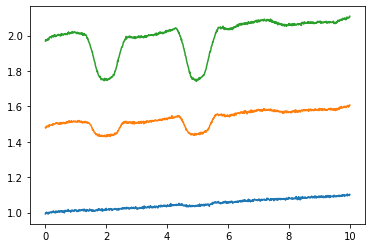

In [3]:
t = np.linspace(0, 10, 1000)
y = tm.sample(t)
pl.plot(t, y)

In [4]:
import theano.tensor as tt
def MvUniform(label, lower, upper):
    n = len(lower)
    lower = tt.as_tensor_variable(lower)
    upper = tt.as_tensor_variable(upper)
    logprob = tt.log(1 / tt.prod(upper - lower))
    logp = lambda x: tt.switch(tt.all(x < upper) and tt.all(x > lower), logprob, -np.inf)
    random = lambda point=None, size=None: lower + np.random.rand(n)*(upper - lower)
    return pm.DensityDist(label, logp, random=random, shape=n)

In [ ]:
import exoplanet as xo
with pm.Model() as model:

    nw = 3
    tm = models.TransitModel(nw=nw, nterms=1, nbodies=2, ramp=True)
    tm.params = {'u1': MvUniform("u1", lower=[0.0]*nw, upper=[1.0]*nw),
                 'u2': MvUniform("u2", lower=[0.0]*nw, upper=[1.0]*nw),
                 'sig': pm.MvNormal("sig", mu=[1e-5]*nw, cov=tt.eye(nw)*1e-2, shape=nw),
                 'A': MvUniform("A", lower=[0.0]*nw, upper=[20.0]*nw),
                 'B': MvUniform("B", lower=[0.0]*nw, upper=[20.0]*nw),
                 'delta[0]': pm.Uniform("delta[0]", lower=0.0, upper=10.0),
                 't0[0]': pm.Uniform("t0[0]", lower=0.0, upper=10.0),
                 'b0[0]': pm.Uniform("b0[0]", lower=0.0, upper=1.0),
                 'r0[0]': MvUniform("r0[0]", lower=[0.0]*nw, upper=[1.0]*nw),
                 'delta[1]': pm.Uniform("delta[1]", lower=0.0, upper=10.0),
                 't0[1]': pm.Uniform("t0[1]", lower=0.0, upper=10.0),
                 'b0[1]': pm.Uniform("b0[1]", lower=0.0, upper=1.0),
                 'r0[1]': MvUniform("r0[1]", lower=[0.0]*nw, upper=[1.0]*nw),
                 'alpha[0]': MvUniform("alpha[0]", lower=[0.0]*nw, upper=[20.0]*nw),
                 'log_S0[0]': pm.Normal("log_S0[0]", mu=-10, sd=5),
                 'log_w0[0]': pm.Normal("log_w0[0]", mu=0, sd=5),
                 'log_Q[0]': pm.Normal("log_Q[0]", mu=-np.log(np.sqrt(2)), sd=1)}
    
    t = tt.as_tensor_variable(t)
    pm.Potential("log_likelihood", tm.log_likelihood(t, y))
    map_soln = xo.optimize(start=start, verbose=False)
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar